In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.sparse as sp
import torch

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *
check_device()
print(models_)

CUDA is not available.
+--------------+-----------------------+
| ORGANISM     | MODEL_SBML            |
+==============+=======================+
| ECOLI_core   | e_coli_core_SBML3.xml |
+--------------+-----------------------+
| mus_musculus | mus_iMM1415.xml       |
+--------------+-----------------------+
| homo_sapiens | Recon3D.xml           |
+--------------+-----------------------+


loading e_coli_core_SBML3.xml...
137 genes
72 metabolites
95 reactions with bound max 1000


,count,mean,std,min,25%,50%,75%,max
0,95.0,22.21,17.8,1.0,3.5,18.0,40.0,58.0


graph with 95 nodes, 1055 edges
is directed: False
is connected: False connected subgraphs: 2
has self loops: False


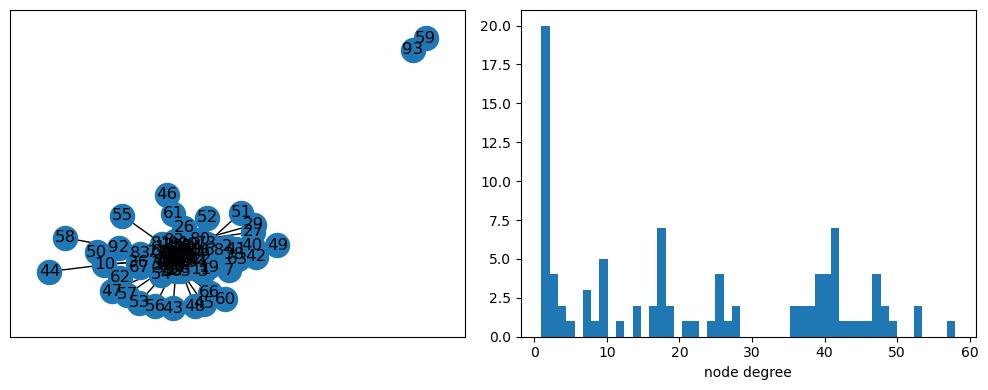

In [2]:
#load model

models_dir = os.path.abspath('../src/sbml_models/')
organism = "ECOLI_core"
sbml_file = libsbml.readSBMLFromFile(os.path.join(models_dir, models[organism]))

gene_exp_scale = 10
bound_max = 1000
model = metabolic_model(organism, sbml_file, bound_max=bound_max)
metabolic_model = model


#get GSMM graph params
S = model.S
S_matrix = model.S_matrix
reactions = list(model.reactions.keys())
metabolites = list(model.metabolites.keys())

S_bool = np.array(S_matrix.astype('bool').astype('int'))
RAG = np.matmul(S_bool.T, S_bool)
adj = RAG.astype('bool').astype('int') 
adj = adj - np.identity(adj.shape[0]) #remove self loops ##symmetric boolean adj matrix
A = sp.csr_matrix(adj)
G = nx.from_scipy_sparse_array(A)

degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
nx.draw_networkx(G, ax = ax)
ax = axes[1]
ax.hist(degrees, bins=50)
ax.set_xlabel("node degree")
fig.tight_layout()


print(f'graph with {len(G.nodes)} nodes, {len(G.edges)} edges')
print(f'is directed: {G.is_directed()}')
print(f'is connected: {nx.is_connected(G)}', 
      f'connected subgraphs: {len([G.subgraph(c).copy() for c in nx.connected_components(G)])}')
print(f'has self loops: {any(G.has_edge(node, node) for node in G.nodes)}')

# Metabolic Vertex-Weighted Graph Generation

genes in both:  137 
 genes in model:  137


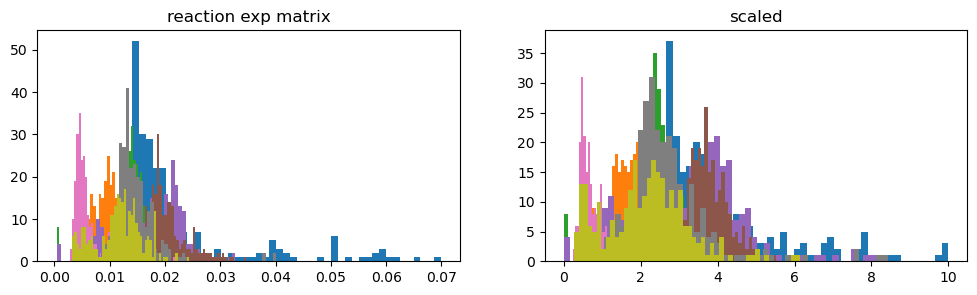

In [3]:
data_path = os.path.abspath('../data/e_coli_data/')
metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'), index_col = 0)
log_tpm = pd.read_csv(os.path.join(data_path, 'log_tpm.csv'), index_col = 0)
#renormalize
raw_data = 2**log_tpm
data_norm = np.sqrt(raw_data)

#format to match GSMM labels
data_norm.index = data_norm.index.str.upper()
####S0001 == B0002
data_norm.rename(index={'B0002':'S0001'}, inplace= True)

##rm
'''
failed........(236, 'fps__fps_ptsI_ale1__1') with error 2
failed........(237, 'fps__fps_ptsI_ale1__2') with error 2
failed........(238, 'fps__fps_ptsI_ale3__1') with error 2
failed........(239, 'fps__fps_ptsI_ale3__2') with error 2
failed........(236, 'fps__fps_ptsI_ale1__1') with error 2
failed........(237, 'fps__fps_ptsI_ale1__2') with error 2
failed........(238, 'fps__fps_ptsI_ale3__1') with error 2
failed........(239, 'fps__fps_ptsI_ale3__2') with error 2
'''

data_norm.drop(data_norm.columns[236:240], axis=1, inplace = True)
metadata.drop(metadata.index[236:240], axis=0, inplace = True)


model_genes = list(model.genes.values())
print('genes in both: ', np.isin(data_norm.index, model_genes).astype('int').sum(), '\n',
      'genes in model: ', len(model_genes) 
     )

reaction_exp_matrix = map_reactions(model, data_norm)
R_, srm_ = scale_reaction_matrix(reaction_exp_matrix, gene_exp_scale, plot= True)
R, srm = merge_tx_model(model, R_, srm_)



In [84]:
data_norm

,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
S0001,45.359293,47.343613,57.779096,61.567991,46.282817,41.919097,31.739348,35.397304,49.005893,48.739939,...,35.155137,35.219017,47.645537,48.010858,57.214231,58.204086,61.425453,62.319790,53.750462,54.810517
B0003,36.958315,38.361015,52.415346,59.792417,41.888781,39.366736,27.827054,34.195898,43.682057,43.128770,...,33.827985,33.322628,35.682900,36.659767,43.962854,43.854065,45.631619,45.861548,39.729825,41.703532
B0004,39.326654,41.141743,37.495226,41.920408,36.694341,33.289027,20.689240,23.281552,34.120707,33.879186,...,37.727234,37.198588,40.497772,41.125931,47.559274,47.057748,48.248007,49.211461,44.526828,45.270621
B0005,8.926229,8.749795,6.548045,6.355741,10.253430,9.224253,4.970788,5.198432,9.605273,8.386587,...,7.942204,7.223975,8.895404,8.849954,5.772789,5.343463,6.607243,7.356276,7.658076,7.486592
B0006,10.988217,10.919225,10.467336,10.492616,10.417280,10.616719,10.149827,10.778003,10.785891,10.620208,...,18.197188,17.891410,16.781006,16.403351,12.791074,12.841731,12.676203,12.617731,16.323462,16.594192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B4688,2.356397,2.824328,1.574021,1.000000,2.747637,3.083230,1.315190,1.293155,2.639498,2.027332,...,1.898153,2.197712,1.000000,1.560135,1.599599,1.498516,1.824423,1.418097,1.000000,1.708477
B4693,1.351402,1.639626,2.385998,2.120004,1.837782,2.096790,3.612806,3.128073,4.390379,4.366131,...,1.307155,2.003050,1.000000,1.122618,3.033845,2.829843,2.933799,2.919463,3.227617,3.001720
B4696_1,2.502293,2.416174,3.683827,3.530014,2.045236,2.009970,3.375298,3.167995,2.352758,2.322960,...,2.692207,2.707949,2.636331,2.443751,2.579473,2.565305,2.928554,2.849273,3.058192,3.251172
B4696_2,2.912709,2.977322,3.866357,3.996854,2.495887,2.143756,3.936709,3.887614,2.872552,2.944287,...,2.476844,3.381305,3.045107,2.841131,2.459968,3.644876,3.317664,3.600837,3.344153,3.756769


In [4]:
from utils_ecoli import FBA_ecoli

outs_path = '/Users/hollysteach/Documents/project_krishnaswamy/recomb_paper'
data_outs = os.path.join(outs_path, 'temp_files')
img_outs = os.path.join(outs_path, 'img')

#load (augmented) data

sub_dir = 'augmented_data_current'
f_ = 'aug_graph_obj'
fname = os.path.join(data_outs, sub_dir, f'{f_}.pk')
def pk_load(fname):
    with open(fname, 'rb') as handle:
        return pk.load(handle)
    
graph = pk_load(fname)


#unpack 
bounds = graph.bounds
RES_bio = graph.res_bio
RES_clique = graph.res_clique


solutions_biomass = [res.x for res in RES_bio]
solutions_mwclique = [res.x for res in RES_clique]


#NN input for SV
fname = os.path.join(data_outs, sub_dir, f'aug_NN_features.pk')
obj = {'bounds':bounds,
       'solutions_biomass':solutions_biomass,
       'solutions_mwclique':solutions_mwclique
}
pk_save(obj, fname)
print(len(bounds), len(solutions_biomass),len(solutions_mwclique))

3014 3014 3014


# Max Wt Clique Scattering Network
# ------------------------------------------------------


In [5]:
total_samples = len(graph.f)
psd_features = []
sctdataset = []

for s in range(total_samples):
    feat = graph.f[s]
    data = Data(x=np.array(feat),edge_index=graph.edge_index)
    psd_features += (data.x.tolist())
    sctdataset += [data]



num_trainpoints = int(np.floor(0.6*total_samples))
num_valpoints = int(np.floor(num_trainpoints/3))
num_testpoints = total_samples - (num_trainpoints + num_valpoints)
traindata= sctdataset[0:num_trainpoints]
valdata = sctdataset[num_trainpoints:num_trainpoints + num_valpoints]
testdata = sctdataset[num_trainpoints + num_valpoints:]
print(len(traindata))
print(len(valdata))
print(len(testdata))

batch_size = 80

from torch.utils.data import  DataLoader
def my_collate(batch):
    data = [item for item in batch]
    return data
train_loader = DataLoader(traindata, batch_size, shuffle=True,collate_fn=my_collate)
test_loader = DataLoader(testdata, batch_size, shuffle=False,collate_fn=my_collate)
val_loader =  DataLoader(valdata, batch_size, shuffle=False,collate_fn=my_collate)
    

1808
602
604


init model; total number of parameters: 793
Epoch:-----0
Epoch:-----1
Epoch:-----2


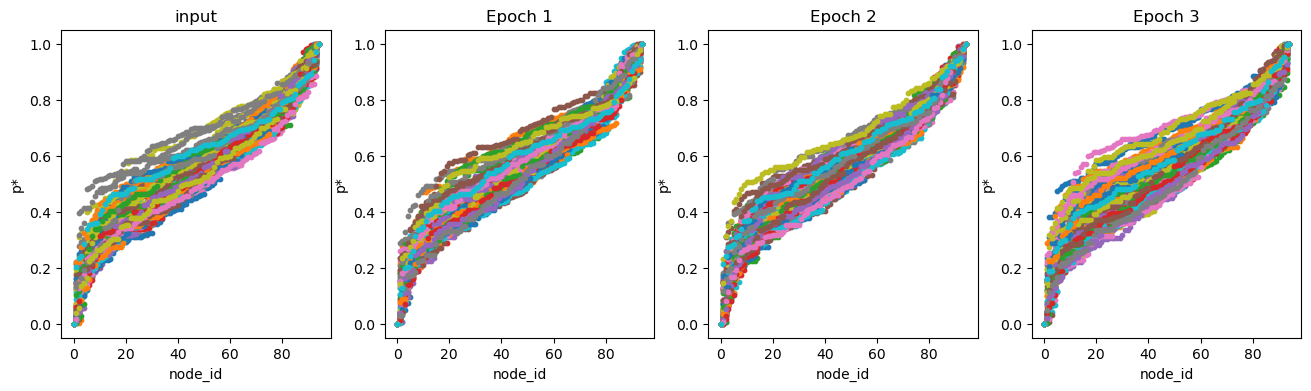

In [29]:
'''
model params
--------------------------------------------------------------------------------
'''

torch.manual_seed(1)
order = 3
N = 95
penalty_coefficient = 0.05
lr = 1e-3
wt_decay = 0

'''
init
--------------------------------------------------------------------------------
'''
    
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=wt_decay) 
model = scattering_GNN(graph,
                    input_dim =4, 
                hidden_dim=8, 
                output_dim=1, 
                n_layers=3)


'''
train
--------------------------------------------------------------------------------
'''


EPOCHS = 3

#progress
fig, axes = plt.subplots(1, (EPOCHS+1), figsize = ((EPOCHS+1)*4,4))
td = [[i,batch] for i, batch in enumerate(train_loader)]
batch = td[0][1]
plot_support(model, batch, ax=axes[0])
axes[0].set_title(f'input')

for i in range(EPOCHS):
    train(model, i, train_loader, optimizer, penalty_coefficient, verbose=False)
    
    td = [[i, batch] for i, batch in enumerate(train_loader)]
    batch = td[0][1]
    
    # Pass the subplot axes as an argument to the plot_support function
    plot_support(model, batch, ax=axes[i + 1])
    axes[i + 1].set_title(f'Epoch {i + 1}')


In [54]:
output

tensor([[0.2400],
        [0.9067],
        [0.5979],
        [0.7466],
        [0.4072],
        [0.3425],
        [0.4666],
        [0.3580],
        [0.7278],
        [0.4431],
        [0.2026],
        [0.6964],
        [0.0000],
        [0.7137],
        [0.7378],
        [0.7651],
        [0.9999],
        [0.9733],
        [0.4656],
        [0.5287],
        [0.5847],
        [0.6759],
        [0.7309],
        [0.5350],
        [0.6861],
        [0.9616],
        [0.4844],
        [0.7267],
        [0.3516],
        [0.5847],
        [0.9307],
        [0.8093],
        [0.8697],
        [0.5560],
        [0.9671],
        [0.8799],
        [0.6298],
        [0.6171],
        [0.6253],
        [0.5797],
        [0.6533],
        [0.6574],
        [0.5094],
        [0.4014],
        [0.3302],
        [0.4014],
        [0.3302],
        [0.4014],
        [0.4141],
        [0.6345],
        [0.4813],
        [0.6345],
        [0.5186],
        [0.4542],
        [0.4584],
        [0

In [ ]:
Numofwalkers = 3
SampLength = 40

In [59]:
output_dis = output
thresholdloopnodes = 50
walkerstart = 0

In [67]:
N = graph.N
edge_index = graph.edge_index
adjmatrix = to_sparse_mx(edge_index, N)
adjmatrix = sparse_mx_to_torch_sparse_tensor(adjmatrix)
_sorted, indices = torch.sort(output_dis.squeeze(),descending=True)
initiaprd = 0.*indices  # torch zeros
initiaprd = initiaprd.numpy() 
for walker in range(min(thresholdloopnodes,N)):
    if walker < walkerstart:
        initiaprd[indices[walker]] = 0.
    else:
        pass
initiaprd[indices[walkerstart]] = 1.

In [75]:
for clq in range(walkerstart+1,min(thresholdloopnodes,N)): 
    initiaprd[indices[clq]] = 1.
    binary_vec = np.reshape(initiaprd, (-1,1)) 
    ZorO = np.sum(binary_vec)**2  - np.sum(binary_vec)

In [74]:
np.sum(binary_vec)**2 - np.sum(binary_vec)

2450.0

In [41]:
def test(loader):
    index = 0
    clilist = []
    timelist = []
    model.eval()
    model.cpu()
#    average_p = [] # calculate average \beta p CompE p
    with torch.no_grad():
        for i, batch in enumerate(loader):
            for j in range(len(batch)): # len(batch[0]) len of the batch
                t_0 = time.time()
                features = torch.FloatTensor(batch[j].x).cpu()
                edge_index = batch[j].edge_index
                adjmatrix = to_scipy_sparse_matrix(edge_index)
                edge_index = edge_index.cpu()
                adj = sparse_mx_to_torch_sparse_tensor(adjmatrix).cpu()
                #scattering model
                output = model(features,adj,moment = args.moment,device = 'cpu')
                predC = []
# my decoder
                for walkerS in range(0,min(args.Numofwalkers,adjmatrix.get_shape()[0])): # with Numofwalkers walkers
                    predC += [getclicnum(adjmatrix,output,walkerstart=walkerS,thresholdloopnodes=args.SampLength).item()]
                cliques = max(predC)
                clilist += [cliques]
                t_pred = time.time() - t_0 #calculate  time
                timelist += [t_pred]
# save prediction
#                torch.save(output, 'PredonNodes/SCT_file%d.pt'%index) # save scattering model's output
                index += 1
#        print('Aver penalty: %.4f'%np.mean(np.array(average_p)))
    return clilist,timelist

In [37]:
walkerstart = 0
thresholdloopnoodes = 50

In [35]:
_sorted, indices = torch.sort(output.squeeze(),descending=True)
initiaprd = 0.*indices  # torch zeros
initiaprd = initiaprd.numpy() 

In [39]:
for walker in range(min(thresholdloopnoodes,graph.N)):
        if walker < walkerstart:
            initiaprd[indices[walker]] = 0.
        else:
            pass
initiaprd[indices[walkerstart]] = 1. # the one with walkerstart'th largest prob is in the clique, start with walkerstart


In [44]:
adjmatrix = graph.W

In [45]:
for clq in range(walkerstart+1,min(thresholdloopnoodes,graph.N)):
     initiaprd[indices[clq]] = 1.
     binary_vec = np.reshape(initiaprd, (-1,1)) 
     ZorO = np.sum(binary_vec)**2  - np.sum(binary_vec) - np.sum(binary_vec*(adjmatrix.dot(binary_vec)))

TypeError: dot(): argument 'tensor' (position 1) must be Tensor, not numpy.ndarray

In [49]:
from obj_fxn_maxwtclique import decoder
decoder(graph, model, output)

# only original data
# --------------------------------------------------------

In [42]:
node_rxn_labels = {n:srm.columns[i] for i, n in enumerate(G.nodes)}
graph = base_graph(G)
f = graph.get_input_features(srm)

TypeError: base_graph.get_input_features() missing 1 required positional argument: 'R'

In [ ]:
'''
Metabolic Model Params
----------------
R_EX_o2_e________________________ O2 exchange
R_O2t___________________________ spontaneous diffusion via environmental gradient O2t
      anaerobic condition:  lower bound of the O2 exchange reaction zero flux
      (can model anaerobic as lb=0)
      R_EX_o2_e [ub,lb] = [0, 1000]

R_EX_glc__D_e____________________ glucose uptake
      lb_gluc = -18.5
      exchange reaction written as export, so limit lb not ub
R_ATPM ___________________________ ATP maintenance
      The ATP maintenance reaction (ATPM) is set with a lower bound of 0 and an upper bound of +8.39 
R_BIOMASS_Ecoli_core_w_GAM________ Biomass
      

'''

for rx in ['R_EX_o2_e', 'R_O2t']: 
      rx = metabolic_model.reactions[rx]
      print(f'reactants: {rx.reactants} \n',
            f'products: {rx.products} \n',
            f'is exchange: {rx.is_exchange()} \n'
            )
      
for rx in ['R_EX_glc__D_e', 'R_ATPM', 'R_BIOMASS_Ecoli_core_w_GAM']:
      rx_idx = S_matrix.columns.get_loc(rx)
      r_ = model.reactions['R_BIOMASS_Ecoli_core_w_GAM']
      print(f'{r_.id}...........(ub,lb) {r_.lb, r_.ub}')
      print(f'index: {rx_idx}')


#check exchange
def check_exchange(metabolic_model):
      for key, val in list(model.reactions.items()):
            if val.is_exchange() is True:
                  print(f'{key}......... {val.reversible} .... {list(val.reactants.keys())}, {list(val.products.keys())}')


#check_exchange(model)

reactants: {'M_o2_e': 1.0} 
 products: {} 
 is exchange: True 

reactants: {'M_o2_e': 1.0} 
 products: {'M_o2_c': 1.0} 
 is exchange: False 

R_BIOMASS_Ecoli_core_w_GAM...........(ub,lb) (0.0, 1000)
index: 51
R_BIOMASS_Ecoli_core_w_GAM...........(ub,lb) (0.0, 1000)
index: 15
R_BIOMASS_Ecoli_core_w_GAM...........(ub,lb) (0.0, 1000)
index: 24


In [ ]:
from utils_ecoli import FBA_ecoli
FBA = FBA_ecoli(model, ATP = 8.39, glucose = -10)
bounds = FBA.get_constrained_bounds(R, bound_scale = 1)

bio_c, clique_c = FBA.get_objective_functions(mw_nodes, with_biomass = False, b_weight = 0.8)

RES_bio, solutions_bio = FBA.get_solutions(bio_c)
RES_clique, solutions_clique = FBA.get_solutions(clique_c)


###is biomass in the max wt clique?
m=0
for i, mn in enumerate(list(mw_nodes.values())):
    if np.isin(24, mn):
        print(i)
        m +=1
print(f'# of cliques that include biomass: {m}')
print(f'all clique biomass set to {clique_c[0][24]}')


R_ATPM bounds set to.......  -10.0 1000
R_EX_glc__D_e bounds set to.......  8.39 1000
# of cliques that include biomass: 0
all clique biomass set to 0.0


# Flux Prediction Models
# ------------------------------------------------------

# Random Vis
# ------------------------------------------------

In [ ]:
if 'srm_original' not in globals():
    srm_original = srm.copy()

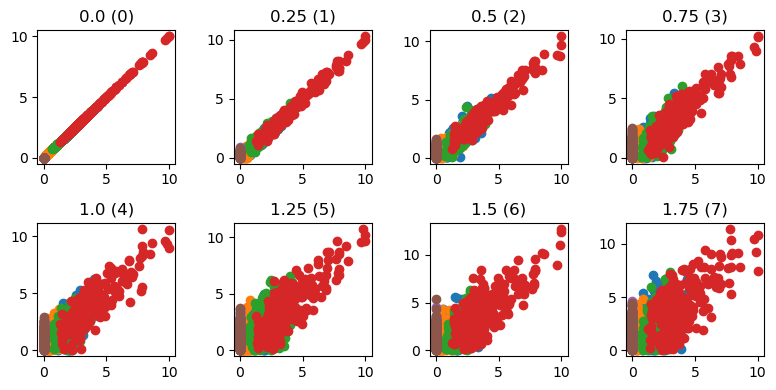

In [ ]:
fig, axes = plt.subplots(2,4, figsize = (8,4))

np.random.RandomState(seed=0)
p_i = np.random.randint(0, 94, 6)

for n in range(0,8):
    noise_stddev = n*0.25
    #noise_stddev += 0.25

    srm_noise = srm_original + np.random.normal(0, noise_stddev, srm_original.shape)
    srm_noise = srm_noise.abs() #all vals >= 0

    ax = axes.flatten()[n]
    for i in p_i:
        ax.scatter(x = srm_original.iloc[:,i], y = srm_noise.iloc[:,i] )
        ax.set_title(f'{noise_stddev} ({n})')

fig.tight_layout()

In [ ]:
#random vis

#boxplot
V = pd.DataFrame([R.x for R in RES_bio], columns = reactions)
sns.boxplot(data = V)
plt.show()


#heatmap
fig, axes = plt.subplots(1, 2, figsize = (12,20))

ax = axes[0]
V = pd.DataFrame([R.x for R in RES_bio], columns = reactions)
sns.heatmap(V.T, ax=ax)
ax.set_title('biomass obj')

ax = axes[1]
V = pd.DataFrame([R.x for R in RES_clique], columns = reactions)
sns.heatmap(V.T, ax=ax)
ax.set_title('max wt clique obj')

fig.tight_layout()

NameError: name 'RES_bio' is not defined

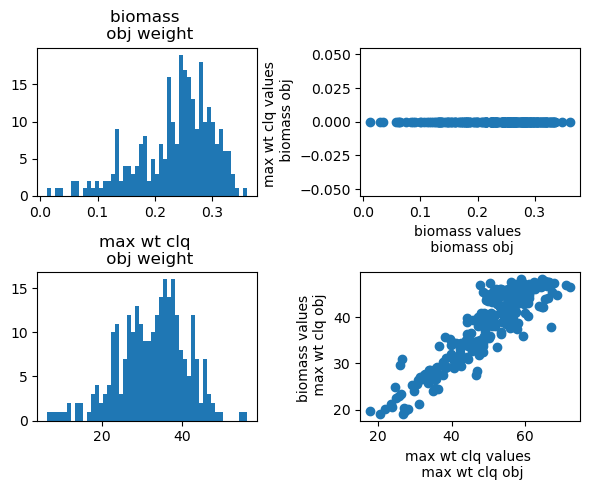

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (6,5))
#obj_dict = [bio_c, clique_c]
#res_dict = [RES_bio, RES_clique]
#soln_dict = [solutions_bio, solutions_clique]
#ids = ['biomass', 'max wt clq (ave)']

for i, ax in enumerate(axes.flatten()):
    i_ = i//2
    obj = [bio_c, clique_c][i_]
    res = [RES_bio, RES_clique][i_]
    soln = [solutions_bio, solutions_clique][i_]
    soln_inv = [solutions_clique, solutions_bio][i_]
    id_  = ['biomass', 'max wt clq'][i_]
    id_inv  = ['max wt clq', 'biomass'][i_]

    if i % 2 == 0:
        #even
        #if normalize- ]
        #/len(np.nonzero(obj[j])[0]
        ax.hist([np.abs(R.fun) for j, R in enumerate(res)], bins = 50)
        #ax.hist([np.mean(R.fun) for R in res], bins = 50)
        ax.set_title(f'{id_} \n obj weight')

    elif i % 2 == 1:
        a = 0
        #x == matched
        #x = [np.abs(R.fun)/len(np.nonzero(obj[j])[0]) for j, R in enumerate(res)]
        c = obj[i]
        x = [np.abs(soln[j]*c).sum() for j, R in enumerate(res)]
        y = [np.abs(soln_inv[j]*c).sum() for j, R in enumerate(res)]
        ax.set_xlabel(f'{id_} values \n {id_} obj')
        ax.set_ylabel(f'{id_inv} values \n {id_} obj')
        ax.scatter(x, y)

fig.tight_layout()


In [ ]:

colors = ["#ACAAE1", "#328CD7", "#DA9D8D", "#D82C0A",'#164B41', "#00997B", "#824B77", "#861A22",'#ECF229',
          "#4146A6", "#8BBF56",'#C9E7F2',"#A65233","#353273", "#F2C84B", "#261810",'#BF4B8B',"#D996B5","#D9D9D9","#B9BF04","#4C1B33",'#96B9D9',"#F27D16","#09577B"
          ]

metadata_dict = {'sample_group': metadata['Condition ID'].astype('str'),
'carbon' : metadata['Carbon Source (g/L)'].astype('str'),
'nitrogen' : metadata['Nitrogen Source (g/L)'].astype('str'),
'electron_acc' : metadata['Electron Acceptor'].astype('str'),
'growth_rate' : metadata['Growth Rate (1/hr)']
}

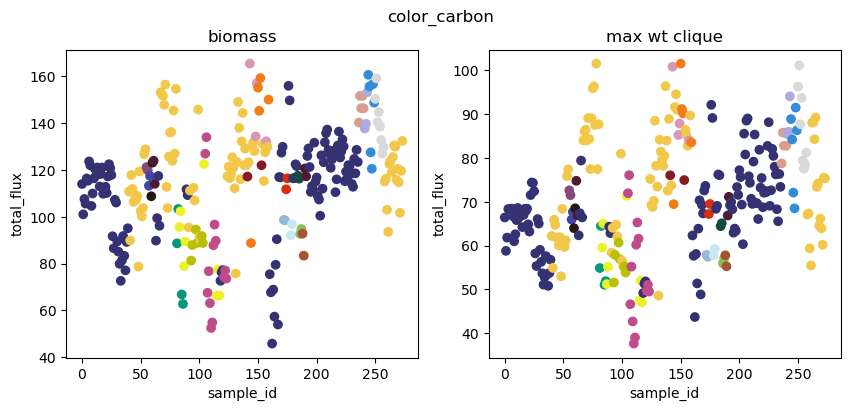

In [ ]:
#c_feats ['sample_group', 'carbon', 'nitrogen', 'electron_acc', 'growth_rate']
c_feat = 'carbon'

#total flux
a = [np.sum(r.x) for r in RES_clique]
b= [np.sum(r.x) for r in RES_bio]
y_feat = [a,b]
plot_metadata(y_feat, c_feat, metadata_dict, colors, 'total_flux')